# HSI image StO2 estimation on INN model

## Preparation

In [1]:
%%capture

from google.colab import drive
drive.mount('/content/drive')

!pip install FrEIA
%cd /content/drive/MyDrive/Trial1/hvs_hsi_pytorch_colab
!pip install -e .

%cd /content/drive/MyDrive/Trial1/HVS_INN_MC_Project_colab

In [2]:
# %matplotlib notebook
name_model = "model_block_GLOW_generic_1"
c = None
exec('import models.' + name_model + "_config as c")

from src.inn_model import *
from src.dataset import *
from src.visualisation import *
from tqdm import tqdm

import glob
import copy
import torch
import pandas as pd
import numpy as np
import time

from hvs_hsi_pytorch.utils import hsi_utils, utils
from hvs_hsi_pytorch.hs_image import HSImage

from sklearn.cluster import MeanShift
from sklearn.neighbors import KernelDensity

In [3]:
# Read reformatted dataset
data_colon = pd.read_csv("data/mc/colon_train_15.7.15.4_power_led_300.csv")

N = len(data_colon)
n_train = int(N * 0.9)
train_df = data_colon[:n_train]

# Data loader
train_dataset = McDataset(train_df, c)
train_loader = data_utils.DataLoader(train_dataset, batch_size=c.batch_size, shuffle=True, drop_last=True)

# Set up dimensionality
c.ndim_y = train_dataset.get_y_dim()
c.ndim_x = train_dataset.get_x_dim()
c.ndim_tot = max(c.ndim_y, c.ndim_x) + c.ndim_z

# Model
model = inn_model(c)
model.load_state_dict(torch.load('models/' + name_model, map_location=torch.device(c.device)))
_ = model.eval()

In [4]:
# Read HSI image data
img_files = glob.glob("data/imgs/frames/*")
n_files, i_files = len(img_files), 0
for i in range(len(img_files)):
    print(('[*]' if i == i_files or i == n_files + i_files else '[ ]') + '\t%s' % (img_files[i].split('/')[-1]))

img_path = img_files[i_files]
white_path = "data/imgs/exported_white_2022-03-10-10-45-04.png"

img = hsi_utils.load_sample(img_path)
white = hsi_utils.load_sample(white_path)

hsi_data = HSImage(array=img, wavelengths=None, camera="imec 4x4-VIS-15.7.15.4")
hsi_data.calibrate(white=white)
hsi_data.demosaic()
hsi_data.correct()
hsi_origin = copy.deepcopy(hsi_data)
hsi_data.array = utils.normalise_L1(hsi_data.array)

# c.target = 1

[*]	exported1465.png
[ ]	image.png
[ ]	exported3971.png
[ ]	exported1979.png
[ ]	exported3561.png
[ ]	exported1868.png
[ ]	exported4034.png


In [5]:
# rows, cols = 3, 3

# # Load validation data loader
# # valid_df = data_colon[n_train:]
# valid_dataset = McDataset(train_df, c)
# valid_loader = data_utils.DataLoader(valid_dataset, batch_size=rows * cols, shuffle=True, drop_last=True)

# z = torch.randn(300, c.ndim_z)

# plt.figure()
# fig, axs = plt.subplots(rows, cols, constrained_layout=True, figsize=(12, 6))

# for x, y in valid_loader:
#     with torch.no_grad():
#         map_x = np.zeros(x.shape[0])
#         for i, j in enumerate(y):
#             print("%d / %d" % (i, len(y)))
#             clear_output(wait=True)

#             pred_x = compute_posterior(model, j, z, c)[:, c.target][:, None]
#             density = KernelDensity(bandwidth=0.01, kernel='gaussian').fit(pred_x)
#             centers = MeanShift(bandwidth=0.02, n_jobs=-1, min_bin_freq=100).fit(pred_x).cluster_centers_
#             plot_x = np.linspace(0, 1, 1000)[:, None]
#             log_dens = density.score_samples(plot_x)
#             dens = np.exp(log_dens) / 100
#             samples = (-0.005 - 0.01 * np.random.random(pred_x.shape[0])) / 100
#             if i == 2:
#                 axs[i // rows][i % rows].axvline(x=x[i][c.target], label='ground truth')
#                 axs[i // rows][i % rows].plot(pred_x[:, 0], samples, "+k", label='samples')
#                 axs[i // rows][i % rows].plot(plot_x[:, 0], dens, color="navy", lw=2, linestyle="-", label='posterior')
#                 axs[i // rows][i % rows].legend()
#             else:
#                 axs[i // rows][i % rows].axvline(x=x[i][c.target])
#                 axs[i // rows][i % rows].plot(pred_x[:, 0], samples, "+k")
#                 axs[i // rows][i % rows].plot(plot_x[:, 0], dens, color="navy", lw=2, linestyle="-")
#     break

In [9]:
# %%time
# times = []

for i in range(16, 20):

    t_start = time.time()
    # Data reformat
    data = hsi_data.array
    shape = data.shape
    data = data.reshape(shape[0], shape[1] * shape[2]).swapaxes(0, 1)

    step = 2 ** i
    batch = list(np.arange(data.shape[0], step=step))
    batch.append(data.shape[0])

    output = torch.tensor([])
    for i in tqdm(range(len(batch) - 1), ascii=True, ncols=100):
        y = data[batch[i]:batch[i + 1]].to(c.device)
        z = torch.randn(y.shape[0], c.ndim_z).to(c.device)
        y = torch.cat((torch.zeros(y.shape[0], c.ndim_tot - c.ndim_y - c.ndim_z).to(c.device), y), dim=1)
        y = torch.cat((z, y), dim=1).to(c.device)
        pred_x = model(y, rev=True)[0][:, c.target].detach().cpu().clone()
        output = torch.cat((output, pred_x))

    output = output.reshape(shape[1], shape[2])[:, :, None]

    t_all = time.time() - t_start
    print(t_all)
    times.append(t_all)

  0%|                                                                         | 0/3 [00:00<?, ?it/s]


RuntimeError: ignored

Text(0, 0.5, 'Time (t)')

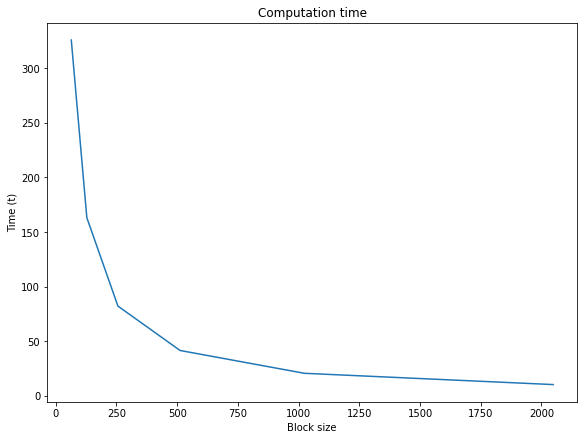

In [31]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(8, 6))

axs.plot([2 ** i for i in range(6, 12)], times[:-8])
axs.set_title("Computation time")
axs.set_xlabel("Block size")
axs.set_ylabel("Time (t)")

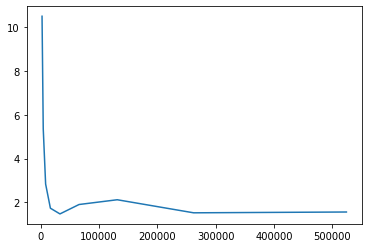

In [22]:
plt.plot([2 ** i for i in range(11, 20)], times[5:])

## HVS Sto2 estimation

In [ ]:
# show_hvs_combo(hsi_origin, mask=True)

In [ ]:
# show_inn_combo_norm(hsi_origin, output, mask=True)

In [ ]:
# show_inn_combo_origin(hsi_origin, output, mask=True, aim_range=(0.8, 1.2))

In [ ]:
# show_inn_combo_range(hsi_origin, output, mask=True, aim_range=(0.5, 1.5))